In [ ]:
import sklearn
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
ps = PorterStemmer()

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/Fake.csv")
real = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/True.csv")

In [ ]:
real['label'] = 1
fake['label'] = 0

# remove prepended source from real news
cleantext = []

for item in real["text"]:
    text = item.partition(" - ")
    cleantext.append(text[2])
real["text"] = cleantext

df = pd.concat([real,fake])
df.size

224490

In [ ]:
df = df.sample(frac = 1, random_state=1)
df.count()

title      44898
text       44898
subject    44898
date       44898
label      44898
dtype: int64

In [ ]:
#drop columns
df = df.drop('title', axis=1)
df = df.drop('subject', axis=1)
df = df.drop('date', axis=1)
df.head()

,text,label
4528,The United States should continue to be “engag...,1
10310,President Trump just tweeted out a new policy ...,0
10937,U.S. Republican presidential candidate Donald ...,1
13470,The Kremlin said on Thursday it was confident ...,1
19397,Kellyanne Conway s response to Williams criti...,0


In [ ]:
df.reset_index(inplace = True)

In [ ]:
df['text'][2]

'U.S. Republican presidential candidate Donald Trump said he does not have to win the New Hampshire primary vote on Tuesday to secure the nomination, apparently tamping down expectations despite holding a double-digit lead in that state’s polls.     The billionaire businessman came in second to Texas Senator Ted Cruz in the Iowa caucuses last week, although polls put him ahead. His candidacy has alarmed the Republican establishment and has been marked by rows, including over his calls for a temporary ban on Muslims entering the United States. No Republican has won the presidential nomination without winning either the Iowa caucuses or the New Hampshire primary since the 1970s, but it would not technically be impossible.  Asked whether a loss in New Hampshire would derail his campaign, Trump told the NBC News show “Meet the Press”: “I don’t think I need it. I hope that I get it.”  “I would like to win but I don’t know that it is necessary.”    Recent opinion polls give him a lead of bet

In [ ]:
len(df)

44898

In [ ]:
len_messages = len(df['text'])

In [ ]:
corpus =[]
for i in range(len_messages):
    # print(i)
    text = re.sub('[^a-zA-Z-@]', ' ', df['text'][i])
    text = text.lower() #küçük harfe çevir
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    corpus.append(text)

In [ ]:
corpus[1]

'presid trump tweet new polici us militari made consult militari expert gener trump made announc would repres major shift militari polici twitter said made decis consult gener militari expert consult gener militari expert pleas advis unit state govern accept allow transgend individu serv capac u militari trump tweet militari must focus decis overwhelm victori cannot burden tremend medic cost disrupt transgend militari would entail thank'

In [ ]:
X = corpus
y = df['label']

In [ ]:
# SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
corpus[2]

'u republican presidenti candid donald trump said win new hampshir primari vote tuesday secur nomin appar tamp expect despit hold double-digit lead state poll billionair businessman came second texa senat ted cruz iowa caucus last week although poll put ahead candidaci alarm republican establish mark row includ call temporari ban muslim enter unit state republican presidenti nomin without win either iowa caucus new hampshir primari sinc would technic imposs ask whether loss new hampshir would derail campaign trump told nbc news show meet press think need hope get would like win know necessari recent opinion poll give lead percentag point next closest contend trump built campaign part around self-declar reput winner loss new hampshir would intensifi doubt translat opinion poll support vote also told meet press spent much million less expect campaign far part media provid much free public peopl like put take commerci trump told show moder chuck todd stori refil restor drop word nd paragr

In [ ]:
EMBEDDING_DIM = 200
w2v_train = list(map(lambda x: x.split(), X_train))
w2v_model = Word2Vec(sentences=w2v_train, size=EMBEDDING_DIM, window=5, workers = 4, min_count=5)

In [ ]:
len(w2v_model.wv.vocab)

29610

In [ ]:
len(X_train)

33673

In [ ]:
type(corpus)

list

In [ ]:
vocab_length = 50_000
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 50000


In [ ]:
input_len = 1000

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_len)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_len)

97381


In [ ]:
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (33673, 1000)
X_test.shape : (11225, 1000)


In [ ]:
embedding_matrix = np.zeros((vocab_length, EMBEDDING_DIM))

for word, token in tokenizer.word_index.items():
    if w2v_model.wv.__contains__(word):
        embedding_matrix[token] = w2v_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (50000, 200)


**MODEL OLUŞTURMA**

In [ ]:
X_train.shape

(33673, 1000)

In [ ]:
model=Sequential()
model.add(Embedding(input_dim = vocab_length,#
                    output_dim = EMBEDDING_DIM,#
                    weights = [embedding_matrix],
                    input_length = input_len,
                    trainable = False))
model.add(LSTM(100, dropout=0.2)) # lstm neuron size
model.add(Dense(1,activation='sigmoid')) # dense layer, activation function
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 200)         10000000  
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,120,501
Trainable params: 120,501
Non-trainable params: 10,000,000
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
421/421 [==============================] - 861s 2s/step - loss: 0.1541 - accuracy: 0.9459 - val_loss: 0.0968 - val_accuracy: 0.9705
Epoch 2/10
421/421 [==============================] - 868s 2s/step - loss: 0.1025 - accuracy: 0.9666 - val_loss: 0.0925 - val_accuracy: 0.9740
Epoch 3/10
421/421 [==============================] - 861s 2s/step - loss: 0.0699 - accuracy: 0.9789 - val_loss: 0.0628 - val_accuracy: 0.9808
Epoch 4/10
421/421 [==============================] - 863s 2s/step - loss: 0.0679 - accuracy: 0.9758 - val_loss: 0.0490 - val_accuracy: 0.9843
Epoch 5/10
421/421 [==============================] - 880s 2s/step - loss: 0.0460 - accuracy: 0.9857 - val_loss: 0.0382 - val_accuracy: 0.9884
Epoch 6/10
421/421 [==============================] - 872s 2s/step - loss: 0.0288 - accuracy: 0.9908 - val_loss: 0.0336 - val_accuracy: 0.9908
Epoch 7/10
421/421 [==============================] - 871s 2s/step - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.0259 - val_accuracy: 0.9926

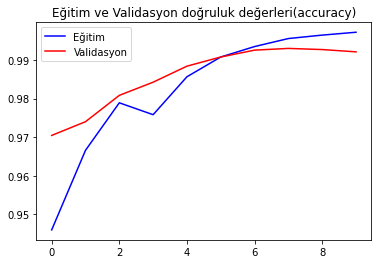

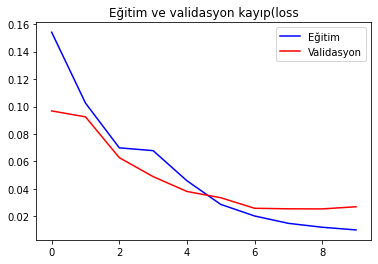

In [ ]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Eğitim')
plt.plot(epochs, val_acc, 'r', label='Validasyon')
plt.title('Eğitim ve Validasyon doğruluk değerleri(accuracy)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Eğitim')
plt.plot(epochs, val_loss, 'r', label='Validasyon')
plt.title('Eğitim ve validasyon kayıp(loss')
plt.legend()


**Test**

Tahmin yapılması

In [ ]:
# Tahmin
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

351/351 [==============================] - 157s 445ms/step


Doğruluk değeri ve karmaşıklık matrisi

Test Verisi doğruluk değeri: 99.2


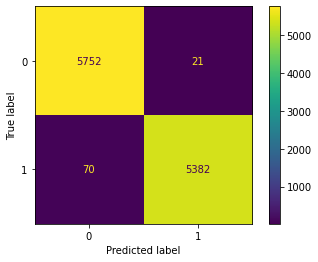

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test,y_pred)
print('Test Verisi doğruluk değeri: %.1f'%(accuracy*100))

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.988     0.996     0.992      5773
           1      0.996     0.987     0.992      5452

    accuracy                          0.992     11225
   macro avg      0.992     0.992     0.992     11225
weighted avg      0.992     0.992     0.992     11225

